# Edge-mounted SMA to co-planar waveguide transition

The subminiature version A (SMA) coaxial connector is an essential component in printed circuit board (PCB) applications. It is commonly used as the interface between the on-board circuit and external components such as antennas or measurement devices. 

In this notebook, we model two edge-mounted SMA connectors attached to a grounded co-planar waveguide (CPW). The connector-to-connector insertion and return losses are calculated to ensure proper impedance matching and minimal reflection. 

<center><img src="./img/sma_edge_mount_render.png" width=600 /></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.plugins.microwave as mw
import tidy3d.plugins.smatrix as sm
from tidy3d import web

td.config.logging_level = "ERROR"

## Building the Simulation

### Key Parameters

In [2]:
# Frequencies and bandwidth
(f_min, f_max) = (1e9, 10e9)
f0 = (f_min + f_max) / 2
freqs = np.linspace(f_min, f_max, 301)

Important geometry dimensions are defined below. The default length unit is microns, so we introduce a `mm` conversion factor. 

In [3]:
mm = 1000  # Conversion factor mm to microns

# Coaxial dimensions (50 ohm)
R0 = 0.635 * mm  # Coax inner radius
R1 = 2.125 * mm  # Coax outer radius

# Substrate overall dimensions
H = 1.57 * mm  # Substrate thickness
Lsub, Wsub = (83 * mm, 30 * mm)  # PCB board dimensions

# Transmission line dimensions
T = 0.038 * mm  #  Metal thickness
WS = 2.58 * mm  # Signal trace width
G = 1 * mm  # CPW gap width
WG = 5 * mm  # Side ground trace width

# Via dimensions
VR = 0.5 * mm  # Via radius
VP = 3 * mm  # Via pitch, longitudinal
VL = 3 * mm  # Via pitch, transverse
VS = 1 * mm  # Via start z-coordinate

# Edge mount dimensions
Voffset = 0.125 * mm  # SMA connector vertical offset

### Medium and Structures

Below, we define the materials used in model:
* PTFE for the SMA dielectric core
* Gold for the SMA body
* FR4 for the PCB substrate
* Copper for the PCB traces

In [4]:
med_FR4 = td.Medium(permittivity=4.4)
med_PTFE = td.Medium(permittivity=2.1)
med_Cu = td.LossyMetalMedium(conductivity=60, frequency_range=(f_min, f_max))  # [S/um]
med_Au = td.LossyMetalMedium(conductivity=41, frequency_range=(f_min, f_max))  # [S/um]

The SMA geometry is imported from a STL file, and then translated and rotated to the appropriate position. The SMA core is created from a `td.Cylinder` instance. To ensure a close fit, we initialize the SMA core to be slightly larger than the inner radius and use Boolean subtraction to cut it to size. 

In [5]:
# Import SMA geometry
geom_SMA = td.TriangleMesh.from_stl(filename="./misc/SMA_model.stl", scale=mm, origin=(0, 0, 0))
geom_SMA = (geom_SMA.rotated(np.pi / 2, 0)).rotated(np.pi, 2)
geom_SMA = geom_SMA.translated(0, Voffset, 0)

# Create SMA dielectric core
geom_SMA_diel = td.Cylinder(
    center=(0, Voffset, -6 * mm / 2), radius=1.1 * R1, length=6 * mm, axis=2
)
geom_SMA_diel -= geom_SMA

We also make a copy for a second connector. 

In [6]:
# Make copy for second connector
geom_SMA2 = (geom_SMA.rotated(np.pi, 1)).translated(0, 0, Lsub)
geom_SMA_diel2 = (geom_SMA_diel.rotated(np.pi, 1)).translated(0, 0, Lsub)

The substrate and CPW geometries are created below. 

In [7]:
# Substrate
geom_sub = td.Box.from_bounds(rmin=(-Wsub / 2, -H - T, 0), rmax=(Wsub / 2, -T, Lsub))

# Transmission line and connecting structures
geom_sig = td.Box.from_bounds(rmin=(-WS / 2, -T, 0), rmax=(WS / 2, 0, Lsub))
geom_gnd1 = td.Box.from_bounds(rmin=(-WS / 2 - G - WG, -T, 0), rmax=(-WS / 2 - G, 0, Lsub))
geom_gnd2 = geom_gnd1.reflected((1, 0, 0))
geom_line = td.GeometryGroup(geometries=[geom_sig, geom_gnd1, geom_gnd2])
geom_gnd = td.Box.from_bounds(rmin=(-Wsub / 2, -H - 2 * T, 0), rmax=(Wsub / 2, -H - T, Lsub))

To ensure proper transmission in the high frequency range, we create a via fence that encloses the signal trace. 

In [8]:
# Create via fence
def create_via_hole(xpos, zpos):
    geom = td.Cylinder(center=(xpos, -H / 2 - T, zpos), axis=1, length=H, radius=VR)
    return geom


geom_via_array = []
zpos = VS
while zpos < Lsub - VS + 0.1 * mm:
    for xpos in [-VL, VL]:
        geom_via_array += [create_via_hole(xpos, zpos)]
    zpos += VP

geom_via_group = td.GeometryGroup(geometries=geom_via_array)

We combine the previously defined geometries and materials into `Structure` instances, ready for simulation.

In [9]:
# Create structures
str_SMA = td.Structure(geometry=geom_SMA, medium=med_Au)
str_SMA2 = td.Structure(geometry=geom_SMA2, medium=med_Au)
str_SMA_diel = td.Structure(geometry=geom_SMA_diel, medium=med_PTFE)
str_SMA_diel2 = td.Structure(geometry=geom_SMA_diel2, medium=med_PTFE)
str_sub = td.Structure(geometry=geom_sub, medium=med_FR4)
str_line = td.Structure(geometry=geom_line, medium=med_Cu)
str_gnd = td.Structure(geometry=geom_gnd, medium=med_Cu)
str_vias = td.Structure(geometry=geom_via_group, medium=med_Cu)

# List of all structures
structure_list = [
    str_SMA,
    str_SMA2,
    str_SMA_diel,
    str_SMA_diel2,
    str_sub,
    str_line,
    str_gnd,
    str_vias,
]

### Grid and Boundaries

The simulation boundaries are open (PML) on all sides. We introduce a padding of wavelength/2 on all sides to ensure that the external boundaries do not encroach on the near-field. 

In [10]:
# Define simulation size and center
padding = td.C_0 / f0 / 2
sim_LZ = Lsub + padding
sim_LX = Wsub + padding
sim_LY = 5 * mm + padding
sim_center = (0, 0, Lsub / 2)

The grid refinement strategy is as follows:
* Use `LayerRefinementSpec` for PCB metallic layers
* Use `MeshOverrideStructure` for SMA dielectric core and metal via fences

In [11]:
# Define layer refinement spec
lr_options = {
    "corner_refinement": td.GridRefinement(dl=0.1 * mm, num_cells=2),
    "min_steps_along_axis": 1,
}
lr1 = td.LayerRefinementSpec.from_structures(structures=[str_line], **lr_options)
lr2 = td.LayerRefinementSpec.from_structures(structures=[str_gnd], **lr_options)

# Define mesh override around SMA core and vias
rbox1 = td.MeshOverrideStructure(
    geometry=geom_SMA_diel.bounding_box, dl=(0.2 * mm, 0.2 * mm, 0.2 * mm)
)
rbox2 = td.MeshOverrideStructure(
    geometry=geom_SMA_diel2.bounding_box, dl=(0.2 * mm, 0.2 * mm, 0.2 * mm)
)
rbox_vias = []
for geom in geom_via_array:
    rbox_vias += [
        td.MeshOverrideStructure(geometry=geom.bounding_box, dl=(0.3 * mm, None, 0.3 * mm))
    ]

The overall grid specification is defined below. 

In [12]:
# Define overall grid specification
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=12,
    wavelength=td.C_0 / f_max,
    layer_refinement_specs=[lr1, lr2],
    override_structures=[rbox1, rbox2] + rbox_vias,
)

### Monitors

We define some field monitors for visualization purposes below. 

In [13]:
# Field Monitor
mon_1 = td.FieldMonitor(
    center=(0, -T - H / 2, 0),
    size=(td.inf, 0, td.inf),
    freqs=[f_min, f0, f_max],
    name="field in-plane",
)
mon_2 = td.FieldMonitor(
    center=(0, 0, 0),
    size=(0, td.inf, td.inf),
    freqs=[f_min, f0, f_max],
    name="field cross section",
)

# List of all monitors
monitor_list = [mon_1, mon_2]

### Ports

Wave ports are positioned along the coaxial section of each SMA connector. 

In [14]:
# Wave port position and dimension
wp_offset = 4 * mm  # longitudinal offset
w_port = 8 * mm  # port width and height

# Current integral for port impedance calculation
I_int = mw.CurrentIntegralAxisAligned(
    center=(0, Voffset, -wp_offset), size=(R0 + R1, R0 + R1, 0), sign="+"
)

# Define wave ports
WP1 = sm.WavePort(
    center=(0, Voffset, -wp_offset),
    size=(w_port, w_port, 0),
    mode_spec=td.ModeSpec(target_neff=np.sqrt(2.1)),
    direction="+",
    name="WP1",
    current_integral=I_int,
    frame=None,
)
WP2 = WP1.updated_copy(
    center=(0, Voffset, Lsub + wp_offset),
    direction="-",
    name="WP2",
    current_integral=I_int.updated_copy(center=(0, Voffset, Lsub + wp_offset), sign="-"),
)

### Defining Simulation and `TerminalComponentModeler`

The `Simulation` and `TerminalComponentModeler` instances are defined below. 

In [15]:
sim = td.Simulation(
    center=sim_center,
    size=(sim_LX, sim_LY, sim_LZ),
    grid_spec=grid_spec,
    structures=structure_list,
    monitors=monitor_list,
    run_time=5e-9,
    plot_length_units="mm",
    symmetry=(1, 0, 0),
)

tcm = sm.TerminalComponentModeler(
    simulation=sim,
    ports=[WP1, WP2],
    freqs=freqs,
)

### Visualization

Before running, it is a good idea to check the structure layout and simulation grid. Below, the top and side cross-sections of the structure is shown, along with the wave ports sources (green arrow) and internal modal absorbers (blue arrow). 

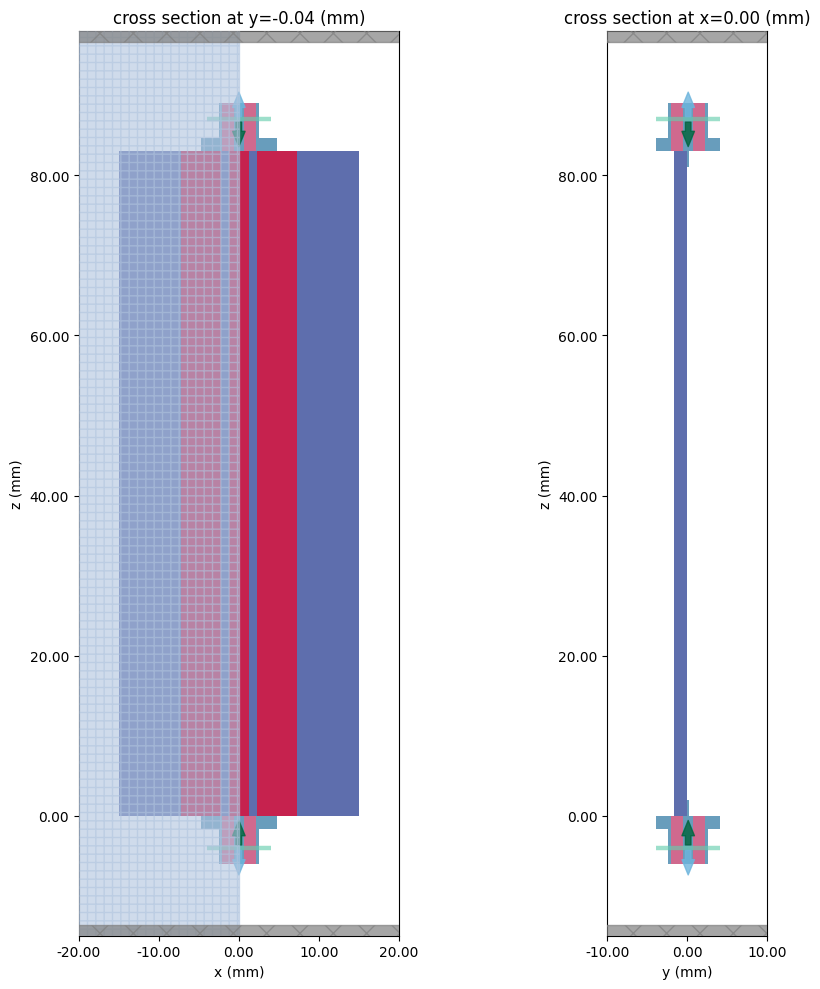

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), tight_layout=True)
tcm.plot_sim(
    y=-T, ax=ax[0], monitor_alpha=0, hlim=(-20 * mm, 20 * mm), vlim=(-15 * mm, Lsub + 15 * mm)
)
tcm.plot_sim(
    x=0, ax=ax[1], monitor_alpha=0, hlim=(-10 * mm, 10 * mm), vlim=(-15 * mm, Lsub + 15 * mm)
)
plt.show()

The grid in the SMA-CPW transition region is shown below. The mesh override regions are boxed with dotted black lines. 

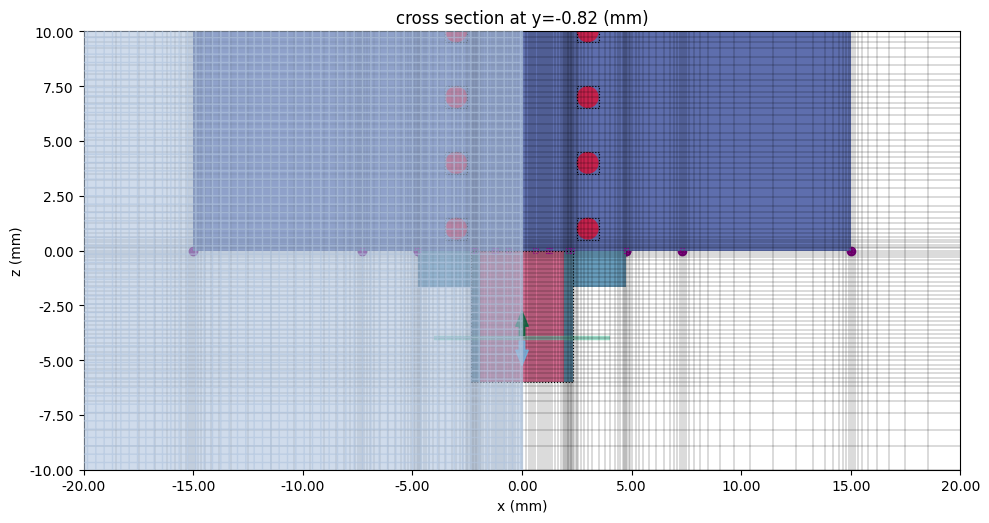

In [17]:
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
tcm.simulation.plot_grid(y=-T - H / 2, ax=ax)
tcm.plot_sim(
    y=-T - H / 2, ax=ax, monitor_alpha=0, hlim=(-20 * mm, 20 * mm), vlim=(-10 * mm, 10 * mm)
)
plt.show()

We can also visualize the setup in 3D. 

In [18]:
sim.plot_3d()

## Running the Simulation

The simulation is executed below. 

In [19]:
tcm_data = web.run(tcm, task_name="sma_connector", path="data/sma_connector.hdf5")

14:18:27 EDT Created task 'sma_connector' with resource_id                      
             'sid-7d07b37a-6775-426c-bdf3-0aa77befce63' and task_type 'RF'.

             View task using web UI at                                          
             ]8;id=46813;https://tidy3d.simulation.cloud/rf?taskId=pa-4b736473-5db4-4765-a650-d31032d7773b\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=483079;https://tidy3d.simulation.cloud/rf?taskId=pa-4b736473-5db4-4765-a650-d31032d7773b\taskId]8;;\]8;id=46813;https://tidy3d.simulation.cloud/rf?taskId=pa-4b736473-5db4-4765-a650-d31032d7773b\=]8;;\]8;id=793128;https://tidy3d.simulation.cloud/rf?taskId=pa-4b736473-5db4-4765-a650-d31032d7773b\pa]8;;\]8;id=46813;https://tidy3d.simulation.cloud/rf?taskId=pa-4b736473-5db4-4765-a650-d31032d7773b\-4b736473-5db4-4765-a6]8;;\
             ]8;id=46813;https://tidy3d.simulation.cloud/rf?taskId=pa-4b736473-5db4-4765-a650-d31032d7773b\50-d31032d7773b']8;;\.

             Task folder: ]8;id=874134;https://tidy3d.simulation.cloud/folders/folder-7d2988e3-13d2-49df-8e7b-f9b5036adc0b\'default']8;;\.

Output()

14:18:31 EDT Child simulation subtasks are being uploaded to                    
             - WP2@0: 'rf-b83af70a-a477-43f4-9b93-d1c9fb469f97'                 
             - WP1@0: 'rf-3fa4cc77-df2a-4d9e-9afb-d852c9f84238'

14:18:33 EDT Validating component modeler and subtask simulations...

             Maximum FlexCredit cost: 0.461. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             Component modeler batch validation has been successful.

14:18:34 EDT Subtasks status - sma_connector                                    
             Group ID: 'pa-4b736473-5db4-4765-a650-d31032d7773b'

Output()

14:22:30 EDT Modeler has finished running successfully.

14:22:31 EDT Billed FlexCredit cost: 0.342. Minimum cost depends on task        
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Output()

14:23:06 EDT loading component modeler data from data/sma_connector.hdf5

## Results

### Field Profile

The field monitor data is accessed from the `.data` attribute of the `TerminalComponentModelerData` result. The key is in the format `<wave port name>@<mode number>`, for example `WP1@0`. (In this case, there is only one mode.)

In [20]:
# Extract simulation data
sim_data = tcm_data.data["WP1@0"]

Below, the `Ex` and `Ey` field components are plotted along the top and side cross-sections respectively. 

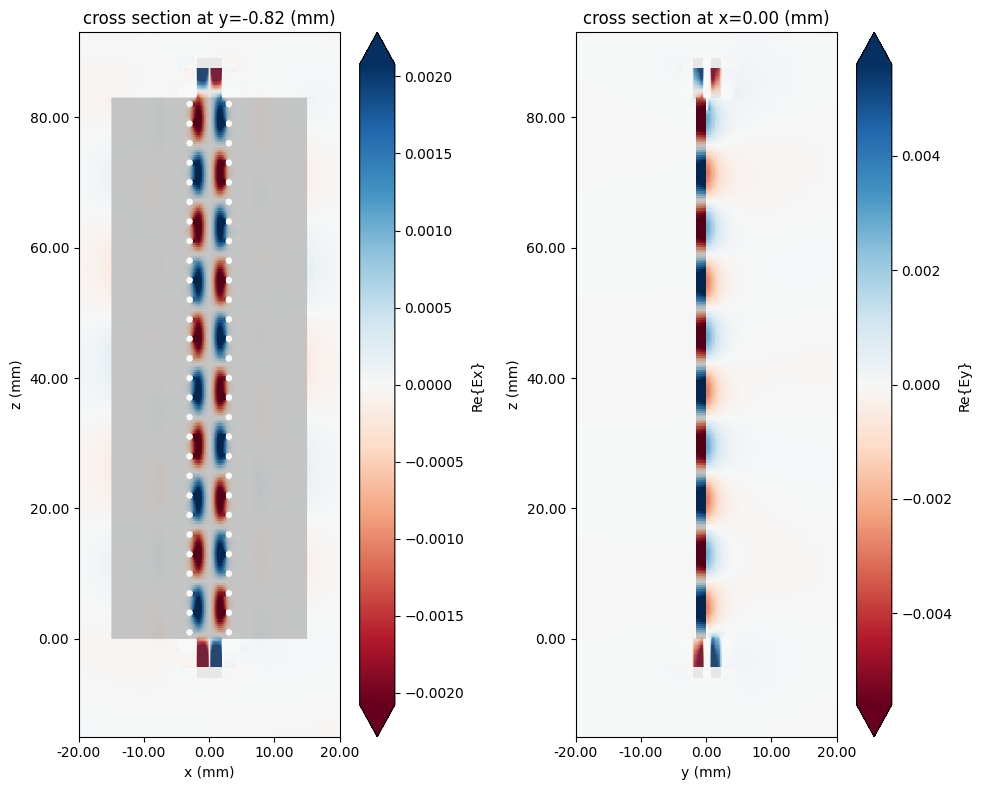

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8), tight_layout=True)
f_plot = f_max
sim_data.plot_field("field in-plane", field_name="Ex", val="real", f=f_plot, ax=ax[0])
sim_data.plot_field("field cross section", "Ey", val="real", f=f_plot, ax=ax[1])
for axis in ax:
    axis.set_ylim(-15 * mm, Lsub + 10 * mm)
    axis.set_xlim(-20 * mm, 20 * mm)
plt.show()

### S-parameters

The S-matrix data is extracted using the `smatrix()` method. To access a specific `S_ij` parameter, use the corresponding `port_in` and `port_out` attributes. Note the use of `np.conjugate` to convert the S-parameter from the physics phase convention (current Tidy3D default) to the usual electrical engineering convention. 

In [22]:
# Extract S-matrix and S-parameters
smat = tcm_data.smatrix()
S11 = np.conjugate(smat.data.isel(port_in=0, port_out=0))
S21 = np.conjugate(smat.data.isel(port_in=0, port_out=1))

The insertion and return losses are plotted below. We observe excellent transmission and minimal reflection across the frequency band, indicating that the impedance of the SMA connector is well-matched to that of the on-board transmission line. 

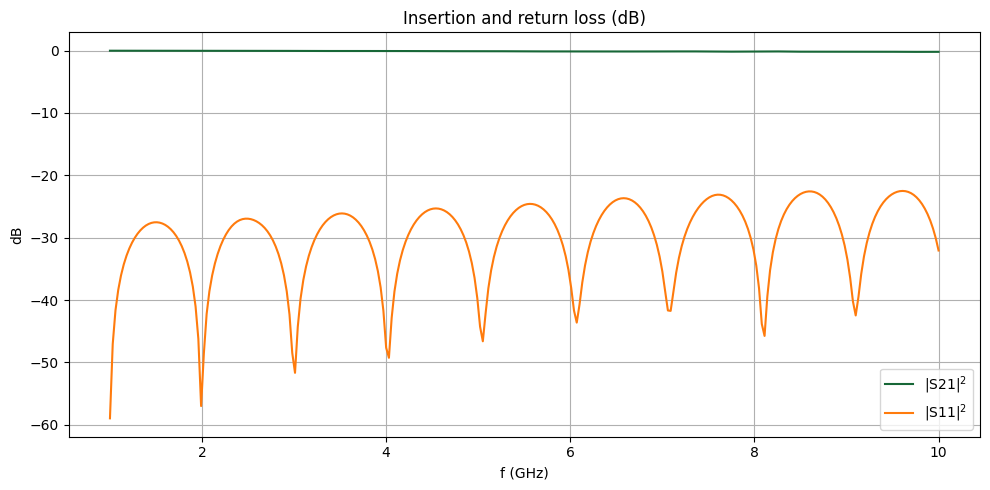

In [23]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S21)), label="|S21|$^2$")
ax.plot(freqs / 1e9, 20 * np.log10(np.abs(S11)), label="|S11|$^2$")
ax.set_title("Insertion and return loss (dB)")
ax.set_xlabel("f (GHz)")
ax.set_ylabel("dB")
ax.legend()
ax.grid()
plt.show()